### 1 获取数据

In [3]:
import yfinance as yf
from datetime import datetime

# 示例调用
stock = 'GOOGL'  # 股票名称
start_date = datetime(2001, 1, 1)  # 开始日期
end_date = datetime(2024, 6, 14)  # 结束日期


def fetch_stock_data(stock, start_date, end_date):
    # 将日期转换为字符串格式
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    # 使用yfinance库获取股票数据
    stock_data = yf.download(stock, start=start_date_str, end=end_date_str)

    # 重命名列
    stock_data.reset_index(inplace=True)
    stock_data.rename(
        columns={'Date': 'Date', 'Open': 'Open', 'High': 'High', 'Low': 'Low', 'Close': 'Close', 'Volume': 'Volume'},
        inplace=True)

    return stock_data, start_date_str, end_date_str


def save_to_csv(dataframe, filename):
    dataframe.to_csv(filename, index=False)
    print(f"Data saved to {filename}")


try:
    stock_data, start_date_str, end_date_str = fetch_stock_data(stock, start_date, end_date)
    filename = f'{stock}_{start_date_str}_{end_date_str}.csv'
    save_to_csv(stock_data, filename)
except Exception as e:
    print(e)

[*********************100%%**********************]  1 of 1 completed


Have not implemented fetching 'earnings' from Yahoo API


### 2.0前沿:导入

In [2]:
import pandas as pd

# 从CSV文件读取数据
all_data_set_path = 'GOOGL_2001-01-01_2024-06-14.csv'
all_data_set = pd.read_csv(all_data_set_path)
print(all_data_set.head())
print(all_data_set.info())  # 查看有多少数据及特征
print(all_data_set.isnull().sum())  # 检查是否有空数据



         Date      Open      High       Low     Close  Adj Close     Volume
0  2004-08-19  2.502503  2.604104  2.401401  2.511011   2.508132  893181924
1  2004-08-20  2.527778  2.729730  2.515015  2.710460   2.707353  456686856
2  2004-08-23  2.771522  2.839840  2.728979  2.737738   2.734599  365122512
3  2004-08-24  2.783784  2.792793  2.591842  2.624374   2.621365  304946748
4  2004-08-25  2.626627  2.702703  2.599600  2.652653   2.649612  183772044
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4989 entries, 0 to 4988
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4989 non-null   object 
 1   Open       4989 non-null   float64
 2   High       4989 non-null   float64
 3   Low        4989 non-null   float64
 4   Close      4989 non-null   float64
 5   Adj Close  4989 non-null   float64
 6   Volume     4989 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 273.0+ KB
None
Date     

#### ①自动编译器

可以学习数据的低维表示，去除噪声。结合LSTM的Autoencoder模型可以更好地捕捉股价数据中的模式，进行有效的降噪。

2024-6-16 16: 对每列数据分别进行降噪，取开盘数据作例子。降噪先不做归一化，但验证误差比训练误差大，可能需要增加训练次数。

2024-6-17 11: 添加降噪前后绘图对比图
##### 优点

* 能处理复杂的非线性关系。
* 能捕捉长期和短期的依赖关系。
* 在降噪的同时还能保留数据的重要特征。

(4979, 10, 1)
Epoch 1/10
125/125 [==============================] - 4s 22ms/step - loss: 20.7863 - val_loss: 62.3166
Epoch 2/10
125/125 [==============================] - 3s 20ms/step - loss: 2.3104 - val_loss: 161.0054
Epoch 3/10
125/125 [==============================] - 3s 21ms/step - loss: 3.2011 - val_loss: 30.7563
Epoch 4/10
125/125 [==============================] - 3s 22ms/step - loss: 1.7807 - val_loss: 114.0976
Epoch 5/10
125/125 [==============================] - 3s 22ms/step - loss: 8.2155 - val_loss: 24.0667
Epoch 6/10
125/125 [==============================] - 3s 22ms/step - loss: 1.3794 - val_loss: 11.7782
Epoch 7/10
125/125 [==============================] - 3s 21ms/step - loss: 1.2355 - val_loss: 12.1914
Epoch 8/10
125/125 [==============================] - 3s 21ms/step - loss: 1.0565 - val_loss: 15.7035
Epoch 9/10
125/125 [==============================] - 3s 21ms/step - loss: 0.8610 - val_loss: 12.7270
Epoch 10/10
156/156 [==============================] - 1s 4ms/ste

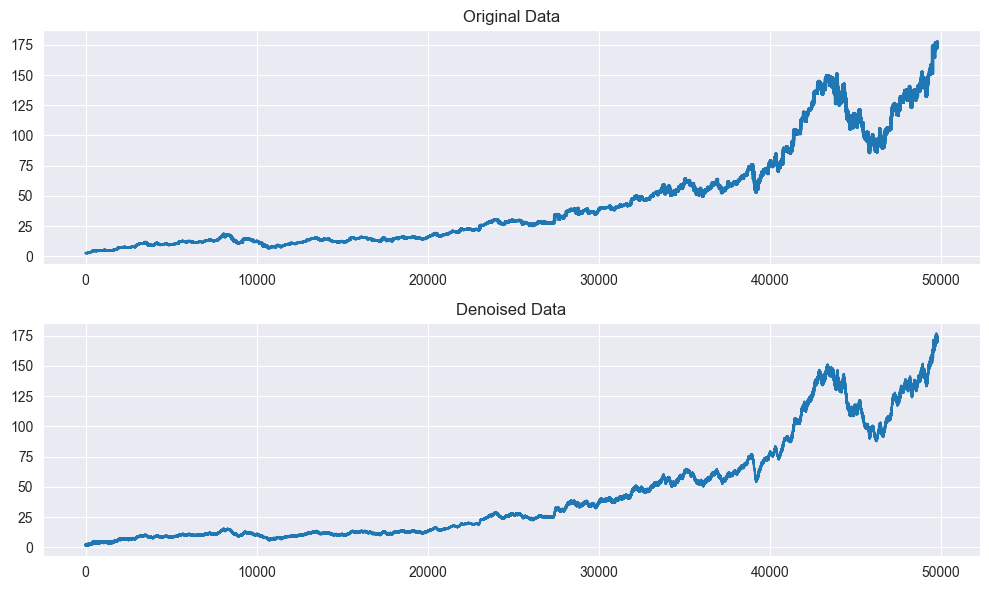

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from matplotlib import pyplot as plt

# 数据预处理
open_data = all_data_set['Open'].values.reshape(-1, 1)
high_data = all_data_set['High'].values.reshape(-1, 1)
low_data = all_data_set['Low'].values.reshape(-1, 1)
close_data = all_data_set['Close'].values.reshape(-1, 1)

# data_set = all_data_set[['Open', 'High', 'Low', 'Close']]
data_set = open_data

# # 归一化
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# prices_scaled = scaler.fit_transform(prices)

# 准备数据
time_steps = 10
X = []
for i in range(len(data_set) - time_steps):
    X.append(data_set[i:i + time_steps])
X = np.array(X)
print(X.shape)

# LSTM Autoencoder模型
input_layer = Input(shape=(time_steps, 1))
encoder = LSTM(64, activation='relu', return_sequences=False)(input_layer)
repeat = RepeatVector(time_steps)(encoder)
decoder = LSTM(64, activation='relu', return_sequences=True)(repeat)
output_layer = TimeDistributed(Dense(1))(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=10, batch_size=32, validation_split=0.2, shuffle=False)

# 用Autoencoder进行降噪
denoised_prices = autoencoder.predict(X)
print(denoised_prices.shape)
# denoised_prices = denoised_prices.reshape(-1, 1)
# denoised_prices = scaler.inverse_transform(denoised_prices)

# 绘图
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(X.flatten())
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(denoised_prices.flatten())
plt.title('Denoised Data')
plt.tight_layout()
plt.show()

#### ②变分模态分解

变分模态分解是一种自适应信号处理方法，可以将时间序列数据分解为若干子信号，从而去除噪声。

VMD在处理非平稳和非线性信号方面表现优异，适用于股价数据的降噪。

2024-6-17 11: 用VMD对开盘数据进行降噪，得到前三阶模态

##### 优点

* 能自适应分解复杂的时间序列。
* 对噪声和非平稳信号处理效果好。

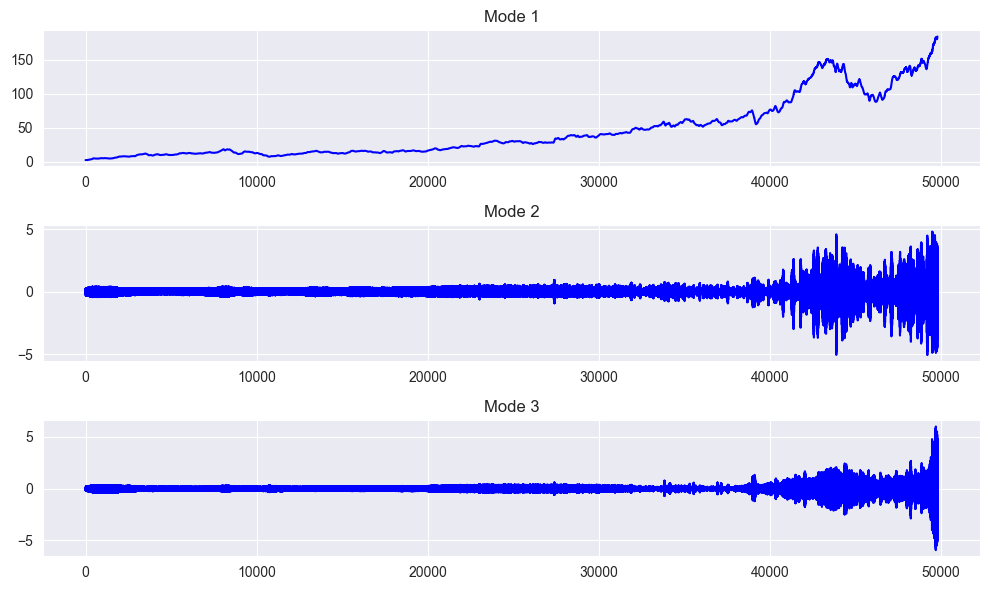

In [18]:
from vmdpy import VMD

# 参数设置
alpha = 2000  # moderate bandwidth constraint
tau = 0.  # noise-tolerance (no strict fidelity enforcement)
K = 3  # number of modes
DC = 0  # no DC part imposed
init = 1  # initialize omegas uniformly
tol = 1e-7

# VMD分解
u, u_hat, omega = VMD(denoised_prices.flatten(), alpha, tau, K, DC, init, tol)

# 绘制VMD结果
plt.figure(figsize=(10, 6))
for i in range(K):
    plt.subplot(K, 1, i + 1)
    plt.plot(u[i], 'b')
    plt.title(f'Mode {i + 1}')
plt.tight_layout()
plt.show()

#### ③卡尔曼滤波

卡尔曼滤波是一种递归算法，能够估计动态系统中变量的状态，适合用于平滑和预测时间序列数据。

在股价数据降噪中，卡尔曼滤波可以用来平滑波动剧烈的股价曲线。

##### 优点

* 实时性强，适合在线处理。
* 能处理动态系统的状态估计，适用于时间序列数据。

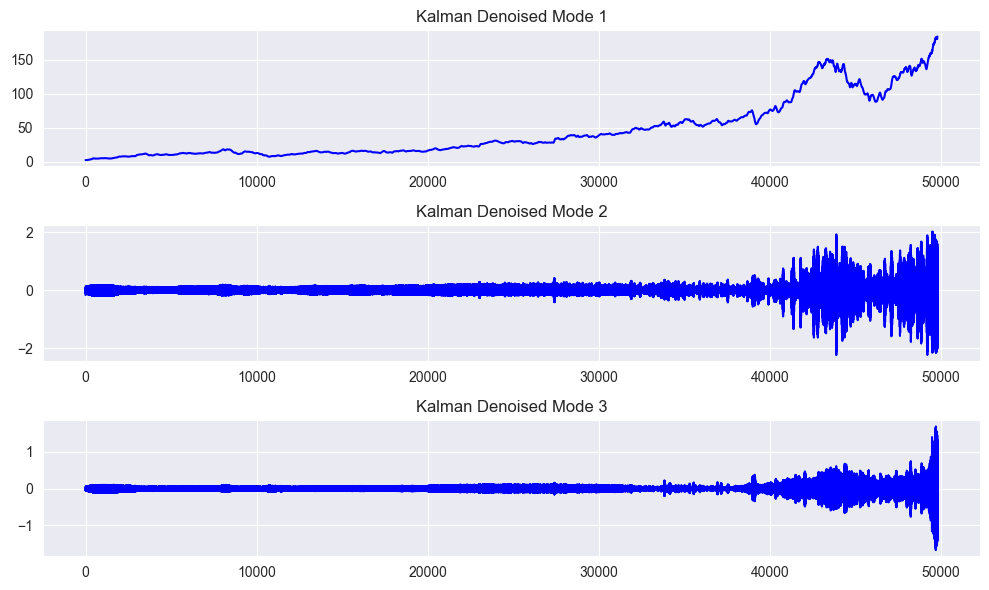

In [19]:
import pykalman
from pykalman import KalmanFilter


# 卡尔曼滤波
def kalman_denoise(signal):
    kf = KalmanFilter(initial_state_mean=signal[0], n_dim_obs=1)
    state_means, _ = kf.smooth(signal)
    return state_means.flatten()


# 对每个模态分量应用卡尔曼滤波
denoised_modes = np.array([kalman_denoise(mode) for mode in u])

# 绘制卡尔曼滤波结果
plt.figure(figsize=(10, 6))
for i in range(K):
    plt.subplot(K, 1, i + 1)
    plt.plot(denoised_modes[i], 'b')
    plt.title(f'Kalman Denoised Mode {i + 1}')
plt.tight_layout()
plt.show()


### 2.2缺失值处理

#注意，接下来两个代码块不是我们要用的，代码部分在后面。并且，我希望先行进行异常值的处理再进行缺失值的处理！（爱你噢噢，郭宝宝厉害~~~）
2024-6-16 16: 去掉date列才能做随机随机森林模型补充缺失值

In [ ]:
# 用（knn）加权平均填充剩余的缺失值
for i in range(len(df)):
    if pd.isnull(df.at[i, col]):
        window_start = max(0, i - window)
        window_end = min(len(df), i + window + 1)
        window_data = df[window_start:window_end][col]

        # 计算权重
        distances = np.abs(window_data.index - i)
        weights = 1 / (distances + 1)  # 防止距离为0

        # 加权平均
        weighted_mean = np.dot(window_data.fillna(0), weights) / weights.sum()
        df.at[i, col] = weighted_mean

return df

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# 示例DataFrame，包含一些缺失值
data = {
    'date': pd.date_range(start='1/1/2015', periods=3000, freq='D'),
    'open': np.random.rand(3000) * 100,
    'high': np.random.rand(3000) * 100,
    'low': np.random.rand(3000) * 100,
    'close': np.random.rand(3000) * 100,
    'volume': np.random.randint(100, 1000, 3000)
}
df = pd.DataFrame(data)

# 引入一些缺失值
nan_indices = np.random.choice(df.index, size=100, replace=False)
df.loc[nan_indices, 'close'] = np.nan

# 检查缺失值
print("缺失值统计:")
print(df.isna().sum())

# 识别含有缺失值的列
missing_columns = df.columns[df.isna().any()].tolist()

# 填补缺失值
for column in missing_columns:
    # 分离数据
    train_data = df[df[column].notna()]
    predict_data = df[df[column].isna()]

    # 特征和标签
    X_train = train_data.drop(columns=missing_columns).drop(columns='date')
    y_train = train_data[column]
    X_predict = predict_data.drop(columns=missing_columns).drop(columns='date')

    # 训练随机森林模型
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # 预测缺失值
    df.loc[df[column].isna(), column] = rf.predict(X_predict)

# 检查是否还有缺失值
print("填补后缺失值统计:")
print(df.isna().sum())

缺失值统计:
date        0
open        0
high        0
low         0
close     100
volume      0
dtype: int64
填补后缺失值统计:
date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


KNN模型（K-Nearest Neighbors Imputation）

#### 优点：

1. **简单直观**：KNN插补方法基于最近邻的观测值进行插补，容易理解和实现。
2. **无模型假设**：KNN插补不需要对数据的分布做出假设，适用于各种类型的数据。
3. **局部插补**：KNN插补利用局部数据进行插补，可以较好地保留数据的局部结构。

#### 缺点：

1. **计算复杂度高**：KNN插补在计算距离时需要遍历整个数据集，计算复杂度为O(n^2)，在数据量较大时计算开销较大。
2. **对异常值敏感**：KNN插补对异常值较为敏感，异常值可能会影响插补结果的准确性。
3. **选择k值**：需要选择合适的k值，不同的k值会影响插补结果，选择不当可能导致插补效果不佳。

### 随机森林模型（Random Forest Imputation）

#### 优点：

1. **处理非线性关系**：随机森林模型能够捕捉数据中的复杂非线性关系，适用于处理股价等复杂数据。
2. **鲁棒性强**：随机森林对异常值和噪声不敏感，具有较强的鲁棒性。
3. **特征重要性评估**：随机森林可以评估特征的重要性，有助于理解数据的结构和特征之间的关系。

#### 缺点：

1. **计算复杂度高**：训练随机森林模型需要较高的计算资源，尤其在数据量较大时训练时间较长。
2. **需要大量样本**：随机森林在样本量较少时效果不佳，可能会过拟合或欠拟合。
3. **参数调优**：随机森林有多个超参数需要调优，如树的数量、最大深度等，调优过程较为复杂。

### 最终选择：

==注意这个代码里面的缺失值是自己随机缺失的，我们的代码应该本身就存在数据缺失，因为存在节假日闭市的情况==

#### 1. 超参数调优

对随机森林模型进行超参数调优，以找到最优参数组合，从而提高模型的性能。可以使用网格搜索或随机搜索进行超参数调优。

#### 2. 特征选择

在填补缺失值时，可以进行特征选择，去除对预测目标影响较小的特征，以减少计算复杂度和过拟合风险。

#### 3. 数据预处理

在填补缺失值之前，可以对数据进行进一步的预处理，如标准化、归一化等，以提高模型的预测性能。

#### 4. 交叉验证

使用交叉验证评估填补后的数据，以确保填补结果的稳健性和一致性。

#### 5.代码部分：
2024-6-17 11: 随机生成数据和一些缺失值，然后用KNN、随机森林模型、迭代随机森林模型填充缺失值，最后对迭代随机森林模型进行评估。

2024-6-17 11: 警告是绘图函数版本问题，不需要理会

数据基本统计信息:
              open         high          low        close       volume
count  2500.000000  2500.000000  2500.000000  2400.000000  2500.000000
mean     50.009558    49.608708    49.851167    49.028045   554.462400
std      28.666445    29.191522    28.933824    28.205553   263.352152
min       0.003679     0.126210     0.003318     0.052005   100.000000
25%      25.404209    23.750645    25.224077    25.474353   327.000000
50%      50.282446    49.692211    48.489976    48.854174   555.000000
75%      74.475714    75.063262    75.069575    72.530301   787.000000
max      99.977451    99.958114    99.950104    99.966892   999.000000
缺失值统计:
open        0
high        0
low         0
close     100
volume      0
dtype: int64


D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32570 (\N{CJK UNIFIED IDEOGRAPH-7F3A}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from font(s) Arial.
  fig.canvas.print_fig

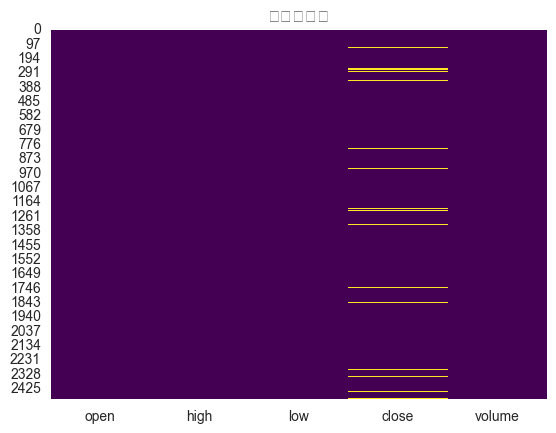

D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20043 (\N{CJK UNIFIED IDEOGRAPH-4E4B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\code\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) Arial.
  fig.canvas.print_fig

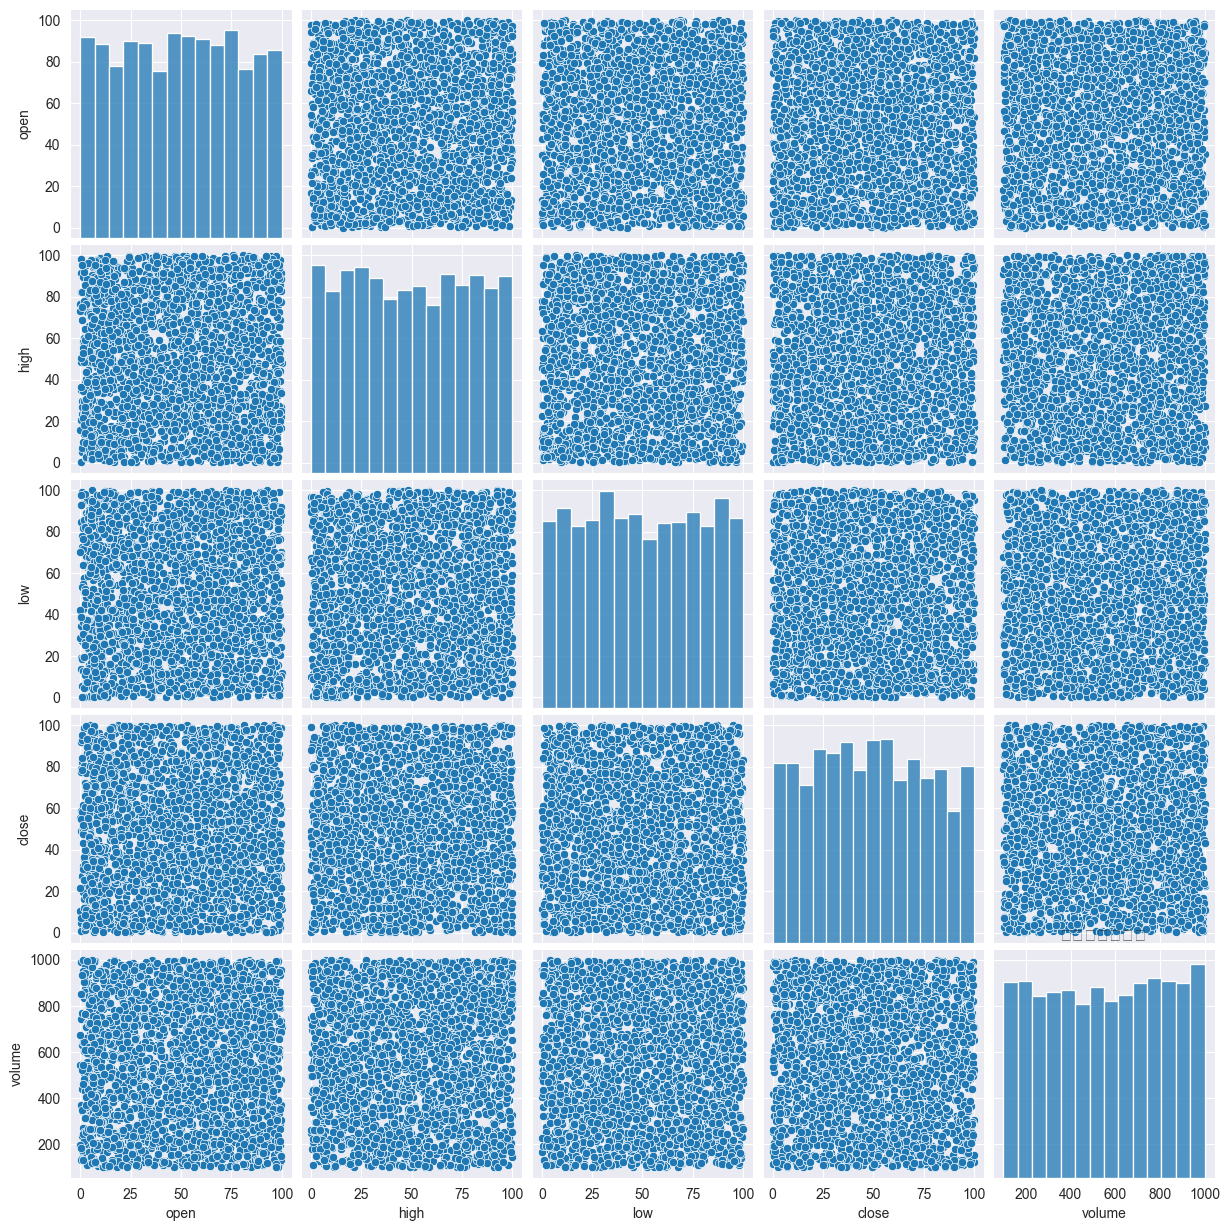

初步KNN后的缺失值统计:
open      0
high      0
low       0
close     0
volume    0
dtype: int64
最佳参数: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
随机森林填补后缺失值统计:
open      0
high      0
low       0
close     0
volume    0
dtype: int64
迭代填补后的缺失值统计:
open      0
high      0
low       0
close     0
volume    0
dtype: int64
交叉验证均方误差: 831.8794409823961
测试集均方误差: 797.6522153258398


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error

# 示例DataFrame，包含2016-2024.6的股价数据和一些缺失值
data = {
    # 'date': pd.date_range(start='1/1/2016', periods=2500, freq='D'),
    'open': np.random.rand(2500) * 100,
    'high': np.random.rand(2500) * 100,
    'low': np.random.rand(2500) * 100,
    'close': np.random.rand(2500) * 100,
    'volume': np.random.randint(100, 1000, 2500)
}
df = pd.DataFrame(data)

# 引入一些缺失值
nan_indices = np.random.choice(df.index, size=100, replace=False)
df.loc[nan_indices, 'close'] = np.nan

# 了解数据分布和缺失值模式
print("数据基本统计信息:")
print(df.describe())

print("缺失值统计:")
print(df.isna().sum())

# 绘制缺失值模式图
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("缺失值模式")
plt.show()

# 绘制特征之间的关系图
sns.pairplot(df.dropna())
plt.title("特征之间的关系")
plt.show()

# KNN填补缺失值
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = df.copy()
df_imputed.iloc[:, :] = knn_imputer.fit_transform(df.iloc[:, :])

# 检查KNN填补后的缺失值
print("初步KNN后的缺失值统计:")
print(df_imputed.isna().sum())

df_ForestRegressor = df.copy()

# 超参数调优
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(df_ForestRegressor.drop(columns=['close']), df_imputed['close'].dropna())

print("最佳参数:", grid_search.best_params_)
best_rf = grid_search.best_estimator_


# 随机森林模型填补缺失值
def fill_missing_rf(df, target_column, model):
    train_data = df[df[target_column].notna()]
    predict_data = df[df[target_column].isna()]

    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_predict = predict_data.drop(columns=[target_column])

    model.fit(X_train, y_train)
    df.loc[df[target_column].isna(), target_column] = model.predict(X_predict)
    return df


df_filled = fill_missing_rf(df_ForestRegressor, 'close', best_rf)

# 检查填补后是否还有缺失值
print("随机森林填补后缺失值统计:")
print(df_filled.isna().sum())

# 迭代填补
iter_imputer = IterativeImputer(estimator=best_rf, max_iter=10, random_state=42)
df_iter_filled = df.copy()
df_iter_filled.iloc[:, :] = iter_imputer.fit_transform(df.iloc[:, :])

# 检查迭代填补后的缺失值
print("迭代填补后的缺失值统计:")
print(df_iter_filled.isna().sum())

# 使用填补后的数据进行模型训练和评估
X = df_iter_filled.drop(columns=['close'])
y = df_iter_filled['close']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 构建和评估随机森林模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 交叉验证
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("交叉验证均方误差:", -cv_scores.mean())

# 在测试集上评估
y_pred = rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("测试集均方误差:", test_mse)


2.3异常值检测并去除

#### 孤立森林：

通过随机选择特征和分割值来构建决策树，并根据样本在树中被分割的路径长度来识别异常点。

**应用**：高效且适用于高维数据，是当前应用较广泛的异常值检测方法之一。

Number of anomalies detected and removed: 103
Number of data points after removal: 4886


C:\Users\admin\AppData\Local\Temp\ipykernel_27460\1125633278.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  anomalies = anomalies.applymap(lambda x: 1 if x == -1 else 0)


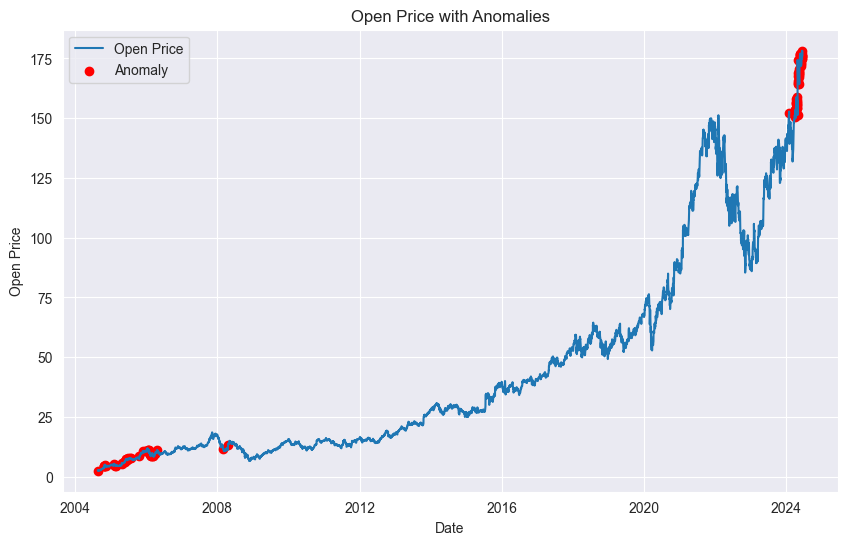

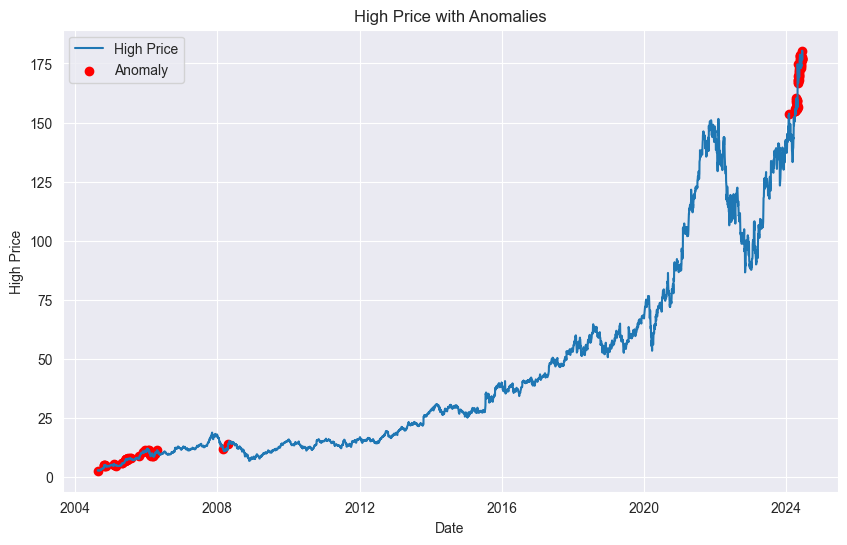

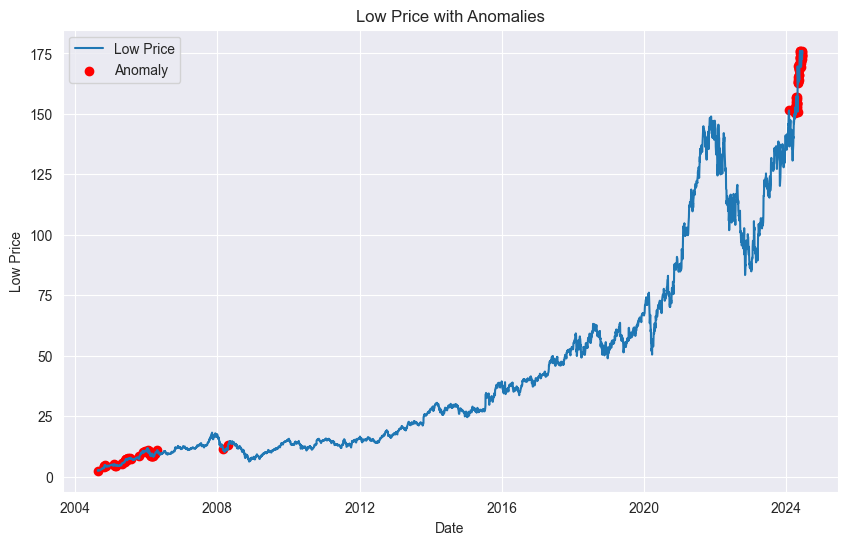

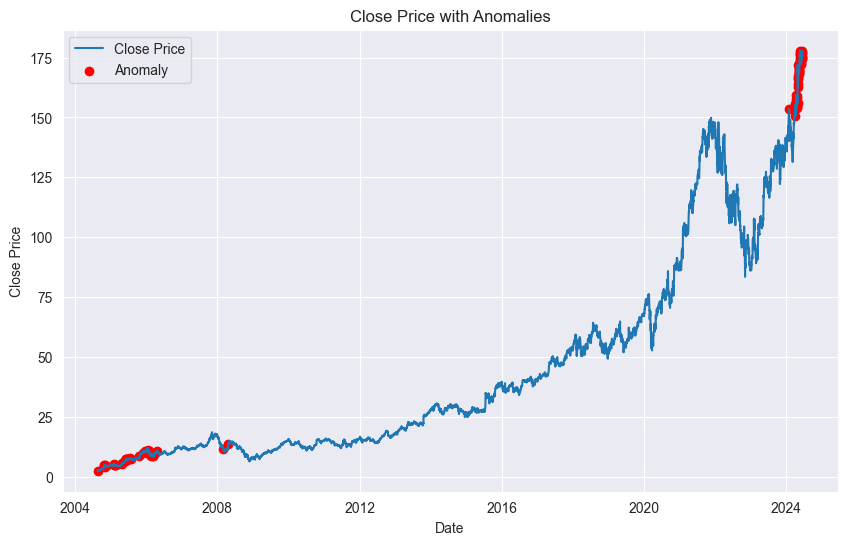

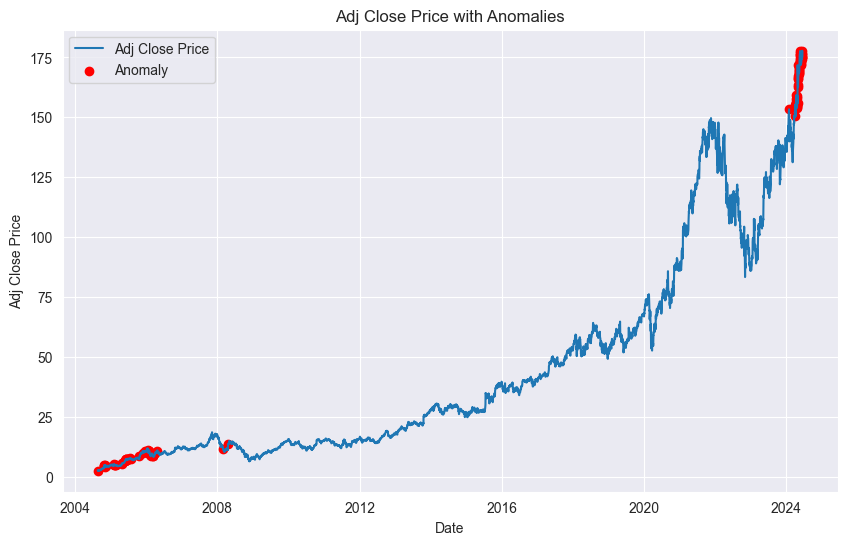

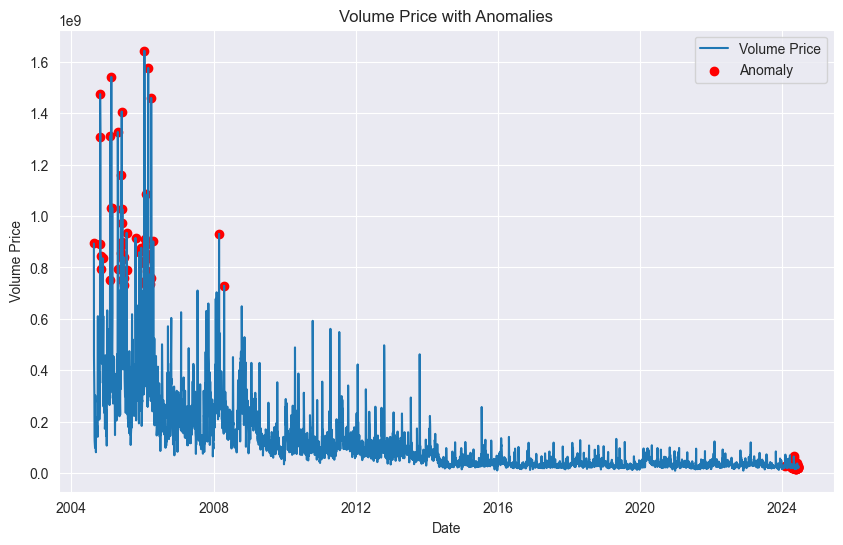

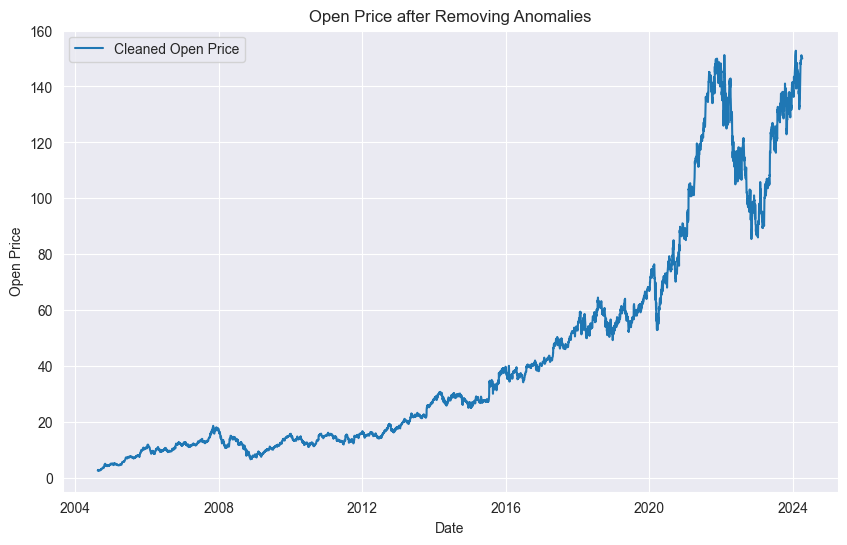

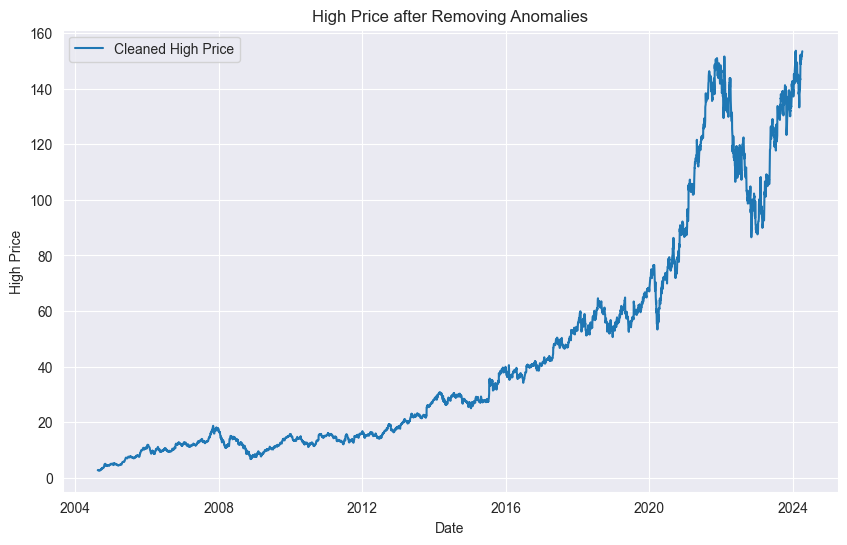

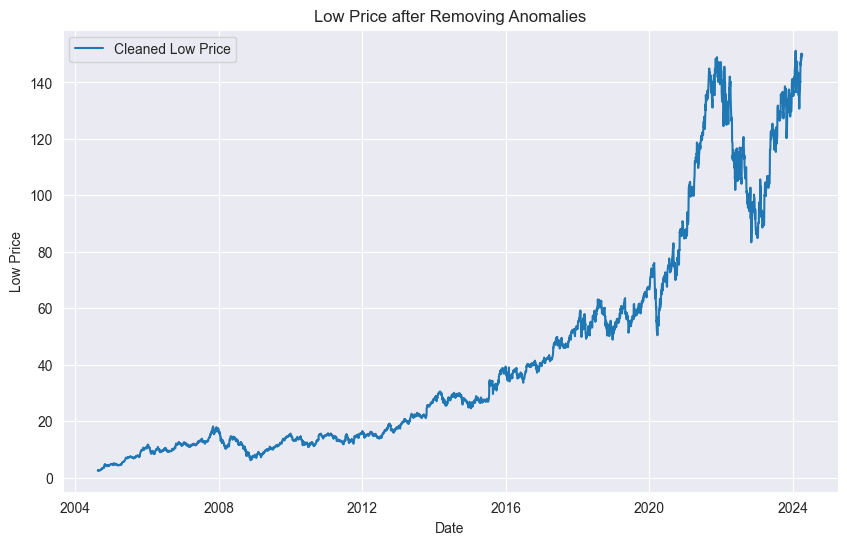

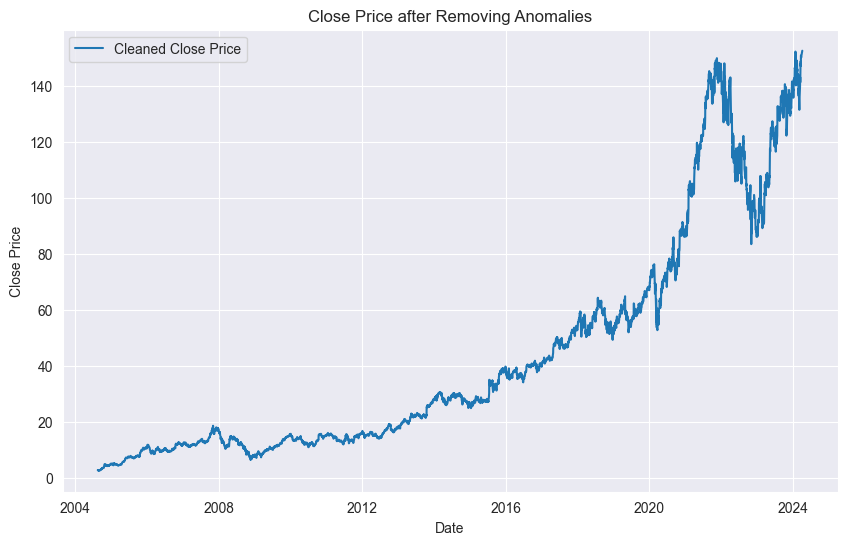

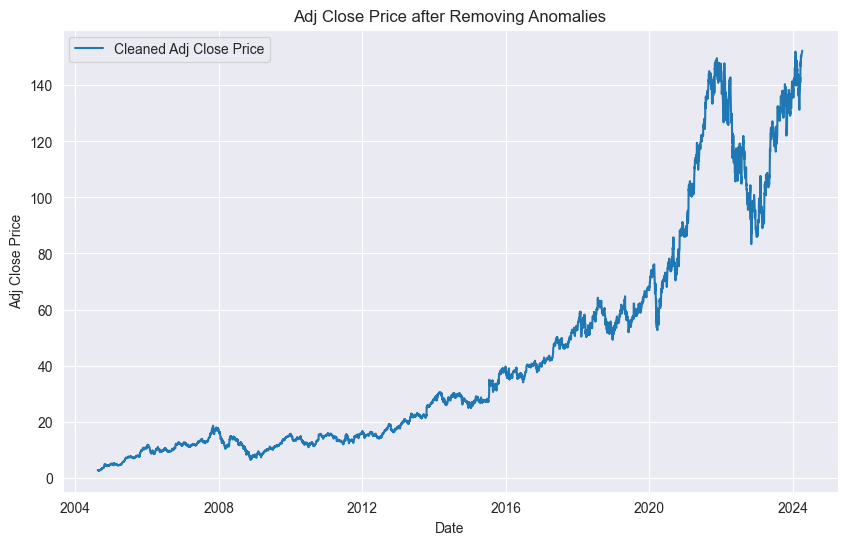

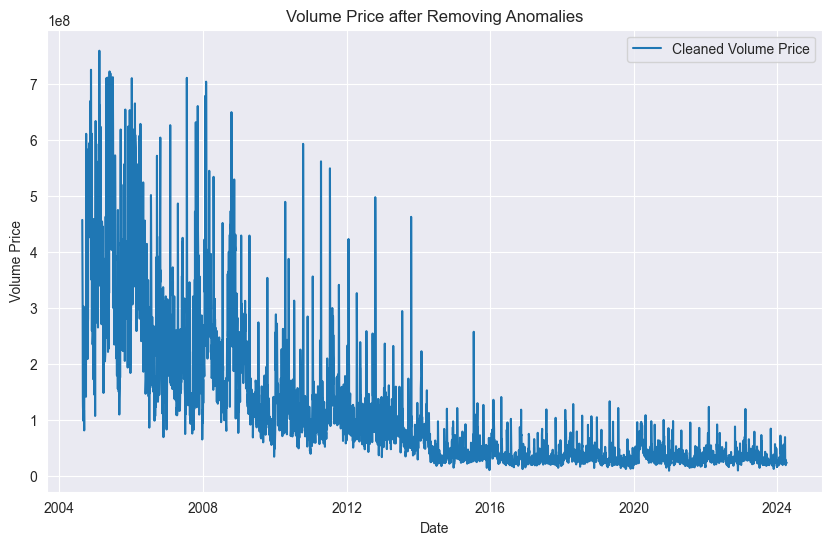

In [14]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 读取股票数据
data = pd.read_csv('GOOGL_2001-01-01_2024-06-14.csv')

# 将日期列转换为日期格式
data['Date'] = pd.to_datetime(data['Date'])

# 初始化孤立森林模型参数
contamination_rate = 0.01  # 异常值比例
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)

# 对每一列进行异常值检测
anomalies = pd.DataFrame(index=data.index)
for column in data.columns:
    if column != 'Date':
        values = data[column].values.reshape(-1, 1)
        anomalies[column] = iso_forest.fit_predict(values)

# 将异常值标记为1，正常值标记为0
anomalies = anomalies.applymap(lambda x: 1 if x == -1 else 0)

# 合并结果，只保留被识别为正常值的数据点
data['Anomaly'] = anomalies.sum(axis=1)
cleaned_data = data[data['Anomaly'] == 0]

# 打印去除异常值后的数据集信息
print(f'Number of anomalies detected and removed: {len(data) - len(cleaned_data)}')
print(f'Number of data points after removal: {len(cleaned_data)}')

# 可视化每个列的结果
for column in data.columns:
    if column != 'Date' and column != 'Anomaly':
        plt.figure(figsize=(10, 6))
        plt.plot(data['Date'], data[column], label=f'{column} Price')
        plt.scatter(data[data['Anomaly'] > 0]['Date'], data[data['Anomaly'] > 0][column], color='red', label='Anomaly')
        plt.xlabel('Date')
        plt.ylabel(f'{column} Price')
        plt.legend()
        plt.title(f'{column} Price with Anomalies')
        plt.show()

# 可视化去除异常值后的数据
for column in data.columns:
    if column != 'Date' and column != 'Anomaly':
        plt.figure(figsize=(10, 6))
        plt.plot(cleaned_data['Date'], cleaned_data[column], label=f'Cleaned {column} Price')
        plt.xlabel('Date')
        plt.ylabel(f'{column} Price')
        plt.legend()
        plt.title(f'{column} Price after Removing Anomalies')
        plt.show()

# 删除Anomaly列
cleaned_data = cleaned_data.drop(columns=['Anomaly'])

# 保存去除异常值后的数据集
cleaned_data.to_csv('cleaned_stock_prices.csv', index=False)


2.4数据标准化

#### 正则化：

In [ ]:
from sklearn.preprocessing import normalize

# 对数据进行正则化
df['Normalized_Price'] = normalize(df[['Denoised_Price']], norm='l2')

### 二、特征工程和因子提取：

为了提取能够反映股票的内在价值和市场行为的有效预测因子，我们对数据进行了特征工程的处理，包括以下几个步骤。

0.有关于特征数量：

"特征数量"（Number of Features）指的是用于训练模型的输入变量的数量。每一个特征（或变量）代表了数据集中的一种测量或属性。例如：日期，开盘价，最高价，最低价，收盘价，成交量等等

#### 特征选择的目的

​ 特征选择的目的是从原始特征集中选择出对预测目标最有用的特征子集，从而提高模型的性能和训练效率。减少不相关或冗余的特征可以帮助减少过拟合，提高模型的泛化能力，并降低计算成本。

#### 提取特征量（类似于盘价，最高价，最低价等）：

其实，这个也是特征构造啦，不知道有没有重复。

In [1]:
import pandas as pd
import talib

# 读取数据
data = pd.read_csv('cleaned_stock_prices.csv')

# 移动平均线
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()

# RSI
data['RSI_14'] = talib.RSI(data['Close'], timeperiod=14)

# MACD
data['MACD'], data['MACD_Signal'], data['MACD_Hist'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26,
                                                                  signalperiod=9)

# 布林带
data['Upper_Band'], data['Middle_Band'], data['Lower_Band'] = talib.BBANDS(data['Close'], timeperiod=20)

# 价格变动百分比
data['Pct_Change'] = data['Close'].pct_change()

# 波动率
data['Volatility'] = data['Pct_Change'].rolling(window=10).std()

# VWAP
data['VWAP'] = (data['Volume'] * (data['High'] + data['Low'] + data['Close']) / 3).cumsum() / data['Volume'].cumsum()

# 查看数据
print(data.head())

# 保存处理后的数据
data.to_csv('processed_dataset.csv', index=False)


         Date      Open      High       Low     Close  Adj Close     Volume  \
0  2004-08-19  2.502503  2.604104  2.401401  2.511011   2.508132  893181924   
1  2004-08-20  2.527778  2.729730  2.515015  2.710460   2.707353  456686856   
2  2004-08-23  2.771522  2.839840  2.728979  2.737738   2.734599  365122512   
3  2004-08-24  2.783784  2.792793  2.591842  2.624374   2.621365  304946748   
4  2004-08-25  2.626627  2.702703  2.599600  2.652653   2.649612  183772044   

   Anomaly  SMA_10    EMA_10  RSI_14  MACD  MACD_Signal  MACD_Hist  \
0        0     NaN  2.511011     NaN   NaN          NaN        NaN   
1        0     NaN  2.547274     NaN   NaN          NaN        NaN   
2        0     NaN  2.581904     NaN   NaN          NaN        NaN   
3        0     NaN  2.589626     NaN   NaN          NaN        NaN   
4        0     NaN  2.601085     NaN   NaN          NaN        NaN   

   Upper_Band  Middle_Band  Lower_Band  Pct_Change  Volatility      VWAP  
0         NaN          NaN   

1.特征构造、

#此处，我们不选择基本面特征和情感分析，因为我认为我国股市并不能够很好地反映公司向外部开放的财务数据，

### ①技术指标

构造常见的技术指标，如移动平均线（MA）、相对强弱指数（RSI）、移动平均收敛散度（MACD）、布林带（Bollinger Bands）等。

### ②时序特征

构造滞后特征、滚动窗口特征等，以捕捉时间序列中的动态变化。

##我记得，你之前那个平滑窗口就是这样##

In [31]:
import pandas as pd
import numpy as np
import ta

# 读取数据
data = pd.read_csv('cleaned_stock_prices.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# 构造常见的技术指标
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['RSI_14'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
macd = ta.trend.MACD(data['Close'])
data['MACD'] = macd.macd()
data['MACD_Signal'] = macd.macd_signal()
data['MACD_Hist'] = macd.macd_diff()
bb = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
data['BB_High'] = bb.bollinger_hband()
data['BB_Low'] = bb.bollinger_lband()
data['BB_Middle'] = bb.bollinger_mavg()
data['VWAP'] = (data['Volume'] * (data['High'] + data['Low'] + data['Close']) / 3).cumsum() / data['Volume'].cumsum()
data['MFI'] = ta.volume.MFIIndicator(data['High'], data['Low'], data['Close'], data['Volume'],
                                     window=14).money_flow_index()
data['AD_Line'] = ta.volume.AccDistIndexIndicator(data['High'], data['Low'], data['Close'],
                                                  data['Volume']).acc_dist_index()
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)
data['Lag_3'] = data['Close'].shift(3)
data['Rolling_Mean_7'] = data['Close'].rolling(window=7).mean()
data['Rolling_Std_7'] = data['Close'].rolling(window=7).std()
data['Rolling_Mean_30'] = data['Close'].rolling(window=30).mean()
data['Rolling_Std_30'] = data['Close'].rolling(window=30).std()
data['Rolling_Max_7'] = data['Close'].rolling(window=7).max()
data['Rolling_Min_7'] = data['Close'].rolling(window=7).min()
data['Rolling_Median_7'] = data['Close'].rolling(window=7).median()
data['Rolling_Quantile_7'] = data['Close'].rolling(window=7).quantile(0.75)
data['Pct_Change_7'] = data['Close'].pct_change(periods=7)
data['Pct_Change_30'] = data['Close'].pct_change(periods=30)
data['Volatility_7'] = data['Close'].rolling(window=7).std()
data['Momentum_14'] = data['Close'].diff(14)
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['DayOfWeek'] = data.index.dayofweek
data['IsMonthStart'] = data.index.is_month_start
data['IsMonthEnd'] = data.index.is_month_end


# 生成每月特征
monthly_data = data.resample('ME').agg({
    'Open': 'first',
    'Close': 'last',
    'High': 'max',
    'Low': 'min',
    'Volume': 'sum'
}).rename(columns={
    'Open': 'Monthly_Open',
    'Close': 'Monthly_Close',
    'High': 'Monthly_High',
    'Low': 'Monthly_Low',
    'Volume': 'Monthly_Volume'
})
data = data.join(monthly_data, how='left').ffill()

data['SMA_10_50_Diff'] = data['SMA_10'] - data['SMA_50']

# 处理NaN值
data_filled = data.bfill().ffill()

float_columns = data_filled.select_dtypes(include=[np.float64, np.float32])

# 查看处理后的数据
print(float_columns.tail())

# 保存处理后的数据
float_columns.to_csv('processed_stock_data.csv')




                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-03-25  149.940002  150.380005  147.820007  150.070007  149.897964   
2024-03-26  150.220001  152.259995  149.979996  150.669998  150.497269   
2024-03-27  151.179993  151.639999  148.899994  150.869995  150.697037   
2024-03-28  150.850006  151.429993  150.169998  150.929993  150.756973   
2024-04-05  150.029999  153.419998  149.600006  152.500000  152.325180   

                SMA_10      SMA_50     RSI_14      MACD  MACD_Signal  ...  \
Date                                                                  ...   
2024-03-25  145.446001  142.981201  63.760709  2.279059     0.723629  ...   
2024-03-26  146.663000  143.153001  64.572093  2.545868     1.088076  ...   
2024-03-27  147.771001  143.317401  64.854567  2.741849     1.418831  ...   
2024-03-28  148.553999  143.486201  64.944865  2.868934     1.708852  ...   
2024-04-05  149.686

2.特征选择、

特征选择的目的是从原始数据中筛选出与预测目标最相关的特征，去除无关或冗余的特征，以减少模型复杂度，提高模型性能。

### ①包裹法——通过交叉验证评估特征子集的效果。

使用特定的机器学习算法（如递归特征消除RFE）对特征进行评估，选择最优特征子集。此处我们可以尝试一下两种方案，进行组合

#### （1）递归特征消除：

Best number of features: 17
Selected Features: Index(['SMA_10', 'SMA_50', 'RSI_14', 'BB_High', 'BB_Middle', 'VWAP', 'AD_Line',
       'Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_7', 'Rolling_Mean_30',
       'Rolling_Max_7', 'Rolling_Min_7', 'Rolling_Median_7',
       'Rolling_Quantile_7', 'Pct_Change_7'],
      dtype='object')
RFE Score: 0.9996050778747587


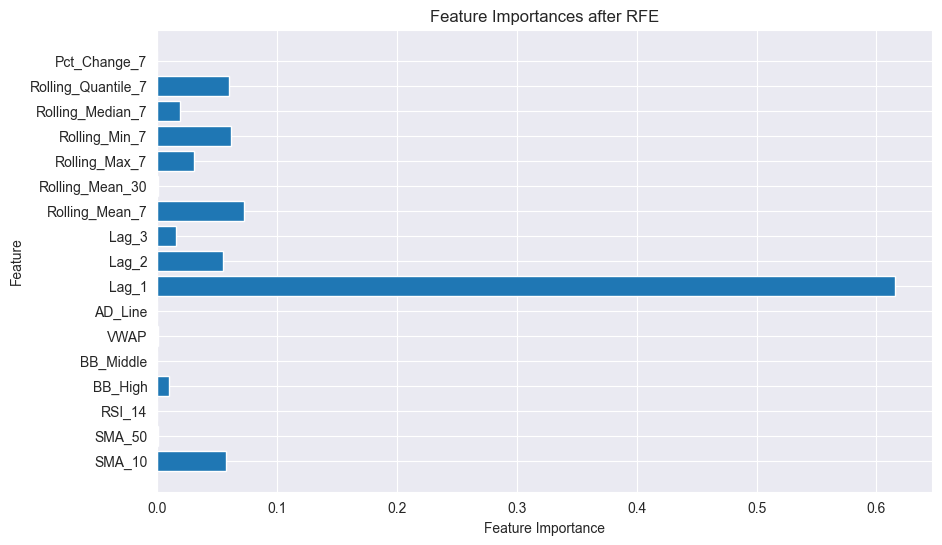

In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('processed_stock_data.csv')
columns_to_keep = ['Open', 'High', 'Low', 'Adj Close', 'Close', 'Date']
X = data.drop(columns=columns_to_keep)

y = data['Close']

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化基模型
base_estimator = RandomForestRegressor(random_state=42)

# 使用GridSearchCV进行超参数调整，以找到最佳特征数量
param_grid = {
    'n_features_to_select': range(1, X_train.shape[1] + 1)
}

# 初始化RFE
rfe = RFE(estimator=base_estimator, step=1)

# 初始化GridSearchCV
grid_search = GridSearchCV(estimator=rfe, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# 拟合模型
grid_search.fit(X_train, y_train)

# 输出最佳特征数量
best_n_features = grid_search.best_params_['n_features_to_select']
print(f'Best number of features: {best_n_features}')

# 使用最佳特征数量重新拟合RFE
rfe = RFE(estimator=base_estimator, n_features_to_select=best_n_features, step=1)
rfe.fit(X_train, y_train)

# 获取选中的特征
selected_features = X.columns[rfe.support_]
print(f'Selected Features: {selected_features}')

# 使用选中的特征进行训练和评估
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
base_estimator.fit(X_train_rfe, y_train)
score_rfe = base_estimator.score(X_test_rfe, y_test)
print(f'RFE Score: {score_rfe}')

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(selected_features, base_estimator.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances after RFE')
plt.show()


版本二：：

In [33]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv('processed_stock_data.csv')
columns_to_keep = ['Open', 'High', 'Low', 'Adj Close', 'Close', 'Date']
X = data.drop(columns=columns_to_keep)
y = data['Close']

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用RFE进行特征选择
estimator = RandomForestRegressor()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

# 打印选出的特征
selected_features = X.columns[selector.support_]
print(f'Selected Features: {selected_features}')

# 将选出的特征保存到文件
selected_features_df = pd.DataFrame(selected_features, columns=['Selected Features'])
selected_features_df.to_csv('selected_features.csv', index=False)

# 使用选出的特征进行训练和评估
X_train_rfe = selector.transform(X_train)
X_test_rfe = selector.transform(X_test)
estimator.fit(X_train_rfe, y_train)
score_rfe = estimator.score(X_test_rfe, y_test)
print(f'RFE Score: {score_rfe}')

# 提取选中的特征数据
selected_data = data[selected_features]

# 合并选中的特征数据和指定的列数据
final_data = pd.concat([data[columns_to_keep], selected_data], axis=1)

# 保存到CSV文件
final_data.to_csv('final_selected_data.csv', index=False)


Selected Features: Index(['SMA_10', 'BB_High', 'Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_7',
       'Rolling_Max_7', 'Rolling_Min_7', 'Rolling_Median_7',
       'Rolling_Quantile_7'],
      dtype='object')
RFE Score: 0.9993137664466448


PermissionError: [Errno 13] Permission denied: 'final_selected_data.csv'

（1）树模型

#### 优点：

1. **直观性**：树模型（如随机森林和梯度提升树）可以直接计算特征重要性，结果易于解释和理解。
2. **鲁棒性**：树模型对非线性关系和特征之间的交互作用敏感，能够有效识别复杂数据模式。
3. **处理缺失值**：树模型可以自然地处理缺失值，不需要对缺失数据进行特殊处理。

#### 缺点：

1. **计算成本**：训练大型随机森林或梯度提升树模型可能会非常耗时，特别是在特征数量较多或数据集较大的情况下。
  
2. **过拟合**：如果模型过于复杂，可能会导致过拟合，特别是在没有进行适当的正则化时。

In [ ]:
###通过超参数调优和交叉验证来减少过拟合，同时通过特征重要性来选择最重要的特征。

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# 1. 加载数据
data = pd.read_csv('processed_stock_data.csv')
X = data.drop(columns=['Close', 'Date'])
y = data['Close']

# 3. 数据分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 超参数调优
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 打印最佳超参数
print("Best parameters found: ", grid_search.best_params_)

# 5. 用最佳超参数训练随机森林模型
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# 6. 特征选择
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# 打印特征重要性
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# 选择前N个最重要的特征
n_important_features = 10  # 选择前10个重要特征
important_features = X.columns[indices][:n_important_features]
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

# 7. 模型评估
# 重新用重要特征训练模型
best_rf.fit(X_train_important, y_train)
test_score = best_rf.score(X_test_important, y_test)
print(f'Test Score with important features: {test_score}')

# 交叉验证评估
cv_scores = cross_val_score(best_rf, X_train_important, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average CV Score: {cv_scores.mean()}')


（2）深度学习类

通过卷积神经网络（CNN）深度学习模型能够自动提取图像中有用的特征，而不需要手动特征工程。

#### 优点：

1. **强大的表示能力**：深度学习模型能够捕捉数据中的复杂非线性关系，适用于高度复杂的特征工程。
2. **自动特征提取**：通过卷积神经网络（CNN），深度学习模型能够自动提取有用的特征，而不需要手动特征工程。
3. **扩展性强**：可以处理大规模数据集，适用于大数据环境。

#### 缺点：

1. **计算成本高**：训练深度学习模型需要大量计算资源，特别是对于大型神经网络。
2. **解释性差**：深度学习模型通常被认为是“黑箱”，难以解释每个特征的重要性和作用。
3. **需要大量数据**：深度学习模型通常需要大量数据进行训练，否则可能无法充分发挥其优势。

In [ ]:
#此处我想要通过CNN从图像数据中提取特征，然后再和随机森林的结合在一起。读取图像
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# 读取股票数据
data = pd.read_csv('your_dataset.csv')
X = data.drop(columns=['target'])  # 替换为实际的目标变量名
y = data['target']

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 图像数据生成器
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


def load_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)


# 假设你有一个包含图像文件路径的列表
image_paths = [...]  # 图像文件路径列表
X_images = load_images(image_paths)

# 分割图像数据集
X_images_train, X_images_test = train_test_split(X_images, test_size=0.2, random_state=42)

###CNN
# 使用预训练的VGG16模型作为特征提取器
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 添加自定义的全连接层并添加Dropout层以减少过拟合
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu')
])

# 冻结预训练模型的卷积层权重
for layer in base_model.layers:
    layer.trainable = False

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 使用早停策略
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 提取图像特征
features_train = model.predict(X_images_train, batch_size=32)
features_test = model.predict(X_images_test, batch_size=32)

# 7. 特征融合
X_train_combined = np.concatenate([X_train_important, features_train], axis=1)
X_test_combined = np.concatenate([X_test_important, features_test], axis=1)

# 8. 模型训练和评估
# 使用交叉验证评估融合特征
model_final = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,
                                    max_features='sqrt', random_state=42)
cv_scores = cross_val_score(model_final, X_train_combined, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average CV Score: {cv_scores.mean()}')

# 训练最终模型
model_final.fit(X_train_combined, y_train)

# 评估模型性能
y_pred = model_final.predict(X_test_combined)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


（3）高级时间序列变分自编码器（VAE）和生成对抗网络（GAN）

如若选择（2）（1）则弃掉（3）

##### 变分自编码器（VAE）

##### 优点：

1. **非线性特征提取**：VAE可以捕捉数据中的复杂非线性关系，适用于非线性时间序列数据。
2. **生成数据**：VAE可以生成新的数据样本，帮助扩充训练数据集，特别是在数据稀缺的情况下。
3. **降维和特征提取**：VAE可以将高维数据映射到低维隐空间，有助于降维和特征提取。
4. **正则化效果**：VAE的变分推断过程内置了正则化效果，可以防止过拟合。

##### 缺点：

1. **计算复杂度**：训练VAE需要较高的计算资源，特别是对于大规模数据集。
2. **模型调参复杂**：VAE有多个超参数需要调节，模型设计和训练过程相对复杂。
3. **不易解释性**：隐空间的特征不易解释，可能需要额外的分析步骤来理解提取的特征。

##### 生成对抗网络（GAN）

###### 优点：

1. **数据生成能力强**：GAN可以生成高质量的合成数据样本，帮助平衡训练数据集，增加模型的泛化能力。
2. **捕捉复杂模式**：GAN能够捕捉数据中的复杂模式和分布，适用于复杂时间序列数据。
3. **增强学习**：GAN可以用于增强学习，通过对抗训练提高模型的鲁棒性和泛化能力。

###### 缺点：

1. **训练不稳定**：GAN的训练过程可能不稳定，容易出现模式崩溃（mode collapse）等问题。
2. **计算资源需求高**：GAN的训练过程需要大量计算资源，特别是对于大规模时间序列数据。
3. **模型解释性差**：生成的特征和数据不易解释，可能需要额外的分析和解释步骤。

VAE:

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K

# 读取数据
data = pd.read_csv('cleaned_stock_prices.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data = data.values  # 转换为numpy数组

# VAE模型参数
original_dim = data.shape[1]
intermediate_dim = 64
latent_dim = 32
batch_size = 128
epochs = 50

# 定义VAE模型
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(data, epochs=epochs, batch_size=batch_size, shuffle=True)

# 提取特征
encoded_data = encoder.predict(data)[0]
encoded_df = pd.DataFrame(encoded_data)
encoded_df.to_csv('vae_encoded_features.csv', index=False)



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           512         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           2080        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense[0][0]']                  
                                                                                            

# GAN

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.optimizers import Adam

# 读取数据
data = pd.read_csv('cleaned_stock_prices.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data = data.values  # 转换为numpy数组

# GAN模型参数
latent_dim = 32
adam = Adam(lr=0.0002, beta_1=0.5)

# 构建生成器
generator = Sequential()
generator.add(Dense(64, input_dim=latent_dim))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dense(data.shape[1], activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

# 构建判别器
discriminator = Sequential()
discriminator.add(Dense(64, input_dim=data.shape[1]))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# 构建GAN
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=adam)

# 训练GAN
epochs = 5000
batch_size = 128

for epoch in range(epochs):
    # 训练判别器
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data = data[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_data = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 训练生成器
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # 打印进度
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

# 使用生成器提取特征
noise = np.random.normal(0, 1, (data.shape[0], latent_dim))
generated_features = generator.predict(noise)
generated_df = pd.DataFrame(generated_features)
generated_df.to_csv('gan_generated_features.csv', index=False)


3.特征变换与特征降维。

通过以上的特征工程的处理，我们得到了一组有效的预测因子，用于构建股票收益率的预测模型。

特征变换通过数学变换将原始特征转换为新的特征，以提高模型的适应性和预测能力

为了优化特征变换中的自编码器算法和t-分布随机邻域嵌入（t-SNE）算法，我们需要关注几个关键点：数据标准化、模型结构设计、超参数调整、以及可视化和解释结果。

#### ①自编码器（Autoencoder）

自编码器是一种无监督的神经网络，用于学习数据的低维表示。自编码器能够捕捉数据中的非线性关系，非常适合处理复杂的时间序列数据。

自编码器是一种无监督学习模型，可以用于特征提取和降维。优化自编码器的方法包括选择合适的网络结构、正则化、早停和超参数调整。

用于对股票数据进行降维和特征变换。自编码器是一种无监督的神经网络，通过将数据压缩到隐藏层（编码层），再将其重建回原始空间，从而学习数据的低维表示。这种方法不仅能有效地降维，还能捕捉数据的非线性特征。

自编码器作为降维和特征变换方法

自编码器由编码器和解码器两部分组成：

* **编码器**：将输入数据压缩到低维表示。
* **解码器**：从低维表示重建原始数据。

##### 优点

* 能够捕捉复杂的非线性关系。
* 提取的特征在低维空间中表示数据的主要结构。
* 适用于大规模数据。

In [35]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv('cleaned_stock_prices.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# 数据标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 拆分数据集
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)

# 自编码器模型参数
input_dim = X_train.shape[1]
encoding_dim = 32

# 构建自编码器模型
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(64, activation='relu')(encoder)
encoder_output = Dense(encoding_dim, activation='relu')(encoder)

decoder = Dense(64, activation='relu')(encoder_output)
decoder = Dropout(0.2)(decoder)
decoder = Dense(128, activation='relu')(decoder)
decoder_output = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder_output)

# 编译模型
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 早停
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True,
                          validation_data=(X_test, X_test), callbacks=[early_stopping])

# 提取编码特征
encoder_model = Model(inputs=input_layer, outputs=encoder_output)
encoded_data = encoder_model.predict(data_scaled)

# 保存编码特征
encoded_df = pd.DataFrame(encoded_data, index=data.index)
encoded_df.to_csv('encoded_features.csv')


Epoch 1/100
16/16 [==============================] - 0s 12ms/step - loss: 1.1628 - val_loss: 1.0472
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.7699 - val_loss: 0.6047
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5294 - val_loss: 0.5293
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.4840 - val_loss: 0.5189
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4785 - val_loss: 0.5183
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4779 - val_loss: 0.5177
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4776 - val_loss: 0.5174
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4769 - val_loss: 0.5172
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4766 - val_loss: 0.5171
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4765 - val_loss: 0.5169
Epoch 11

②t-分布随机邻居嵌入（t-SNE）

t-SNE是一种非线性降维技术，通过保持高维数据的局部结构，将其映射到低维空间。t-SNE主要用于可视化，但也可以用于特征变换。

t-SNE是一种降维和数据可视化的技术，特别适用于高维数据。优化t-SNE的方法包括选择合适的参数（如perplexity和学习率）和数据预处理。

##### 优点

* 能够保留高维数据的局部结构。
* 适用于高维数据的非线性降维和可视化。

##### 缺点

* 计算复杂度高，不适用于大规模数据。
* 难以解释变换后的特征。

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('encoded_features.csv', index_col=0)

# 数据标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# t-SNE参数
perplexity = 30
learning_rate = 200

# 执行t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(data_scaled)

# 可视化t-SNE结果
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'], index=data.index)
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], s=5)
plt.title('t-SNE Visualization')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

# 保存t-SNE结果
tsne_df.to_csv('tsne_features.csv')


③优化建议：

#### 自编码器优化建议

1. **网络结构**：根据数据的复杂性选择合适的网络结构。更多的层数和神经元可以捕捉更复杂的模式，但也可能导致过拟合。
2. **正则化**：使用Dropout和L2正则化来防止过拟合。
3. **早停**：使用早停机制，根据验证集的性能自动停止训练。
4. **超参数调整**：使用网格搜索或贝叶斯优化等方法调整模型超参数，如编码维度、学习率等。

#### t-SNE优化建议

1. **数据预处理**：标准化或归一化数据，以提高t-SNE的效果。
2. **参数选择**：根据数据的规模和分布调整perplexity和学习率。perplexity一般在5到50之间调整，学习率可以尝试10到1000之间的值。
3. **多次运行**：由于t-SNE的随机性，可以多次运行t-SNE，选择最稳定和可解释的结果。
4. **可视化**：结合其他可视化技术，如PCA和UMAP，来验证和解释t-SNE的结果。